## This code uses deep DMD on data generated by making several random load changes for model identification:

Author: Sai Pushpak Nandanoori \
Organization: PNNL \
Date created: December 02, 2020 \

### Basic overview of the deepDMD implementation: 
Original time-series data labeled as: $\begin{bmatrix} x_1 & x_2 & x_3 & \dots & x_{n-1} & x_n \end{bmatrix}$ \
Create the following datasets from the given time-series data:\
$Y_p = \begin{bmatrix} x_1 & x_2 & x_3 & \dots & x_{n-1} \end{bmatrix}$ \
$Y_f = \begin{bmatrix} x_2 & x_3 & \dots & x_{n-1} & x_n \end{bmatrix}$

The time-series data is translated and approapriately scaled. \
Nonlinear observables - given by the encoder - $\psi$ \
State-inclusive observables (linear observables + learnt nonlinear observables) - $\Psi$ \
such that \
$\Psi(x) = \begin{bmatrix} x \\ \psi(x) \end{bmatrix}$ \
One time-step loss: $||\Psi(Y_f) - \mathcal{K} \Psi(Y_p)||_F^2$ \
where $\mathcal{K}$ is the Koopman operator. \
Observed that multi time-step loss is not needed. \ 

To avoid overfitting - weight regularization, dropout are added \
To deal with noisy measurements, regularization on the Koopman operator is implemented \
To deal with lack of data, time-delay embedding of the data is implemented by defining a window size and shift size

### Initial packages declaration and loading the functions needed

In [1]:
import sys
sys.path.append('../../../sai_code/helper_fcns_file/')

In [2]:
import helper_fcns
# import Koopman_helper_fcns
import os
import time
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

[INFO] Tensorflow version:  2.4.1
[INFO] Eager mode:  True


In [3]:
# !jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -ofs 12 -mathfs 100 -N -kl -cursw 5 -cursc r -cellw 95% -T
# !jt -r

In [4]:
N_EPOCHS = 1
keepN = 1000
timing_dict = dict()

### Custom Functions

In [5]:
def get_data(t: tf.string):
    # fetch directory name
    s_dir = t.numpy().decode('utf-8')
    if s_dir.find('scenario') == -1:
        return None
    
    # get and concatenate data
    dataset = helper_fcns.TransientDataset('%s/%s/' % (scenario_dir, s_dir))
    raw_data = np.concatenate((dataset.F, dataset.Vm), axis=1)
    
    # return data
    return raw_data

def convert_to_tensor(i):
    d = tf.py_function(func=get_data, inp=[i], Tout=tf.float64)
    d.set_shape(tf.TensorShape([1400, 136]))
    return d

def get_shape(df):
    for a in df.take(1): 
        nrows = a.cardinality().numpy()
        for b in a.take(1): ncols = b.shape[0]
    return (nrows, ncols)

### Load the data corresponding to several scenarios. The entire data is stored in a single dictionary and each scenario data can be obtained by choosing the key value as the scenario number.

In [6]:
scenario_dir = '../../../../data/TrainingDataIEEE68bus'
print('[INFO]: Loading the datasets from the directory:', scenario_dir)
dir_list = os.listdir(scenario_dir)

# Indicate the scenario range
Dataset = dict()
print('[INFO]: Loading data for %d scenarios ...' % len(dir_list))

l_start = time.time()
list_files = tf.data.Dataset.from_tensor_slices(dir_list)

original_scenarios = list_files.map(convert_to_tensor)
trimmed_scenarios = original_scenarios.map(lambda scenario: tf.data.Dataset.from_tensor_slices(scenario).take(keepN))

l_stop = time.time()

print('[INFO]: Time taken for loading datasets:', l_stop - l_start, 'seconds')
print('[INFO]: Done ...')

[INFO]: Loading the datasets from the directory: ../../../../data/TrainingDataIEEE68bus
[INFO]: Loading data for 30 scenarios ...
[INFO]: Time taken for loading datasets: 0.1679980754852295 seconds
[INFO]: Done ...


In [7]:
i_start = time.time()

window_size = 800
shift = 10
stride  = 1 # stride
M = 2 # signifies number of time-shifts
N = 3 # signifies number of time-shifts

Yp_data = trimmed_scenarios.map(lambda window: window.take(keepN-1))
Yf_data = trimmed_scenarios.map(lambda window: window.skip(1))
window_X_data = trimmed_scenarios.map(lambda window: window.take(keepN-N).window(window_size, shift=shift, stride=stride, drop_remainder=True))
window_Y_data = trimmed_scenarios.map(lambda window: window.skip(1).window(window_size, shift=shift, stride=stride, drop_remainder=True))
window_U_data = trimmed_scenarios.map(lambda window: window.skip(M).window(window_size, shift=shift, stride=stride, drop_remainder=True))
window_V_data = trimmed_scenarios.map(lambda window: window.skip(N).window(window_size, shift=shift, stride=stride, drop_remainder=True))

for a in window_X_data.take(1): n_windows = a.cardinality().numpy()
n_datapoints = len(dir_list)* n_windows * window_size

i_stop = time.time()
print('[INFO]: Time taken for creating X datasets:', i_stop - i_start, 'seconds')
print('[INFO]: Chosen dataset size:', window_size)
print('[INFO]: Number of windows:', n_windows)
print('[INFO]: Number of tuples:', n_datapoints)

[INFO]: Time taken for creating X datasets: 0.564002513885498 seconds
[INFO]: Chosen dataset size: 800
[INFO]: Number of windows: 20
[INFO]: Number of tuples: 480000


In [8]:
# step-3: normalization
n_start = time.time()

scale_factor = 2 * np.pi 
normalization = 1

flat_Yp_data = Yp_data.flat_map(lambda time_step: time_step)
flat_Yf_data = Yf_data.flat_map(lambda time_step: time_step)

flat_X_data = window_X_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_X_data = window_X_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_Y_data = window_Y_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_U_data = window_U_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
flat_V_data = window_V_data.flat_map(lambda window: window.flat_map(lambda time_step: time_step))
if normalization:
    flat_Yp_data = flat_Yp_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                         tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    flat_Yf_data = flat_Yf_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                         tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    flat_X_data = flat_X_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    flat_Y_data = flat_Y_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    flat_U_data = flat_U_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    flat_V_data = flat_V_data.map(lambda x: tf.concat([tf.math.multiply(tf.math.subtract(x[:68], 60), scale_factor), \
                                                       tf.math.multiply(tf.math.subtract(x[68:], 1), 10)], axis=0))
    
n_stop = time.time()
print('[INFO]: Time taken for normalization:', n_stop - n_start, 'seconds')

[INFO]: Time taken for normalization: 0.6789669990539551 seconds


In [9]:
plt_data = []
for row in flat_X_data.take(600):
    plt_data.append(row)
    
plt_data = np.array(plt_data)

(600, 136)


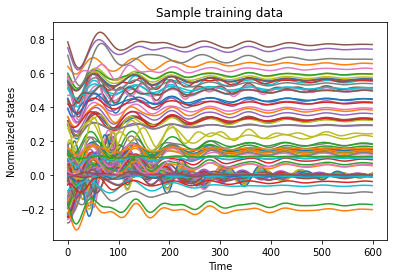

In [10]:
print(plt_data.shape)
plt.plot(np.arange(0,600),plt_data)
plt.xlabel('Time')
plt.ylabel('Normalized states')
plt.title('Sample training data')
plt.show()

### Define the dense layer and initialize it based on the Xavier initialization. This layer is used in the encoder as a dense layer (except for the last layer). 
- using the 'elu' activation function (noticed that 'tanh' has the similar performance)
- Keeping all the datatypes to 'float64'

In [11]:
class DenseLayer(tf.keras.layers.Layer):

    def __init__(self, units, weights_regularizer, bias_regularizer):
        super(DenseLayer, self).__init__(dtype = 'float64')
        self.units = units
        self.weights_regularizer = weights_regularizer
        self.bias_regularizer = bias_regularizer
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.w = self.add_weight(shape = (input_dim, self.units), 
                                 initializer = tf.keras.initializers.RandomUniform(
                                     minval=-tf.cast(tf.math.sqrt(6.0/(input_dim+self.units)), dtype = 'float64'),  
                                     maxval=tf.cast(tf.math.sqrt(6.0/(input_dim+self.units)) , dtype = 'float64'),  
                                     seed=16751), 
                                 regularizer = tf.keras.regularizers.l1(self.weights_regularizer), 
                                 trainable = True)
        self.b = self.add_weight(shape = (self.units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(self.bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        return tf.nn.elu(x)

### Define the linear layer and initialize it based on the Xavier initialization.  This layer is used in the encoder as a last layer. 

In [12]:
class LinearLayer(tf.keras.layers.Layer):

    def __init__(self, units, weights_regularizer, bias_regularizer):
        super(LinearLayer, self).__init__(dtype = 'float64')
        self.units = units
        self.weights_regularizer = weights_regularizer
        self.bias_regularizer = bias_regularizer
    
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.w = self.add_weight(shape = (input_dim, self.units), 
                                initializer = tf.keras.initializers.RandomUniform(
                                minval=-tf.cast(tf.math.sqrt(6/(input_dim+self.units)), dtype = 'float64'), 
                                maxval=tf.cast(tf.math.sqrt(6/(input_dim+self.units)), dtype = 'float64'), 
                                seed=16751),                                                                   
#                               regularizer = tf.keras.regularizers.l1(self.weights_regularizer), 
                                trainable = True)
        self.b = self.add_weight(shape = (self.units,),    
                                 initializer = tf.zeros_initializer(),
                                 regularizer = tf.keras.regularizers.l1(self.bias_regularizer),
                                 trainable = True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

### Define the nonlinear observables as a encoder
- Only drawback here is to manually define the number of layers need to be used in the encoder. 

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, hps):
        super(Encoder, self).__init__(dtype = 'float64', name = 'Encoder')
        self.input_layer   = DenseLayer(hps.h1, 0.0, 0.0)
        self.hidden_layer1 = DenseLayer(hps.h2, hps.wr, hps.br)
        self.dropout_laye1 = tf.keras.layers.Dropout(hps.dr)
        self.hidden_layer2 = DenseLayer(hps.h3, hps.wr, hps.br)        
        self.dropout_laye2 = tf.keras.layers.Dropout(hps.dr)
        self.hidden_layer3 = DenseLayer(hps.h4, hps.wr, hps.br)
        self.dropout_laye3 = tf.keras.layers.Dropout(hps.dr)           
#         self.hidden_layer4 = DenseLayer(hps.h5, hps.wr, hps.br)
#         self.dropout_laye4 = layers.Dropout(hps.dr)             
        self.output_layer  = LinearLayer(hps.ld, hps.wr, hps.br)
        
    def call(self, input_data, training):
        fx = self.input_layer(input_data)        
        fx = self.hidden_layer1(fx)
        if training:
            fx = self.dropout_laye1(fx)     
        fx = self.hidden_layer2(fx)
        if training:
            fx = self.dropout_laye2(fx) 
        fx = self.hidden_layer3(fx)
        if training:
            fx = self.dropout_laye3(fx) 
#         fx = self.hidden_layer4(fx)
#         if training:
#             fx = self.dropout_laye4(fx)
        return self.output_layer(fx)

### Complete Neural Network with the encoder, state-inclusive observables and the 1 time-step loss for Koopman

In [14]:
# Neural Network
class NeuralNetworkModel(tf.keras.Model): 
    def __init__(self, hp):
        super(NeuralNetworkModel, self).__init__()
        self.encoder = Encoder(hp) 
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
        # Define and randomly initialize the Koopman operator
        self.KO = tf.Variable(tf.random.normal(shape = (hp.ld+hp.od, hp.ld+hp.od), mean=0.0, stddev=0.05, 
                                                    dtype=tf.dtypes.float64, seed=123321, name='KoopmanOperator'),
                                                    trainable=True)
        self.rf = hp.rf 
        
    def train_step(self, inputs):       
        X        = inputs[0]
        Y        = inputs[1] 
        
        with tf.GradientTape() as tape:
            Psi_X    = self.encoder(X, training=True)
            Psi_Y    = self.encoder(Y)    

            PSI_X    = tf.concat([X, Psi_X], 1)
            PSI_Y    = tf.concat([Y, Psi_Y], 1) 

            # 1-time step evolution on observable space:
            K_PSI_X  = tf.matmul(PSI_X, self.KO) 
            
            # 1-step Koopman loss on observable space:        
            K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

            # Regularization loss on Koopman operator:
            Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        
        
            # Total loss:
            loss = K_loss + Reg_loss
            loss += sum(self.encoder.losses)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"loss": self.loss_tracker.result()}
        
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]
    
    def test_step(self, inputs):       
        X = inputs[0]
        Y = inputs[1] 

        Psi_X    = self.encoder(X)
        Psi_Y    = self.encoder(Y)    

        PSI_X    = tf.concat([X, Psi_X], 1)
        PSI_Y    = tf.concat([Y, Psi_Y], 1) 

        # 1-time step evolution on observable space:
        K_PSI_X  = tf.matmul(PSI_X, self.KO) 

        # 1-step Koopman loss on observable space:        
        K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

        # Regularization loss on Koopman operator:
        Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        

        # Total loss:
        loss = K_loss + Reg_loss
        loss += sum(self.encoder.losses)
            
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"loss": self.loss_tracker.result()}
        
    def predict_step(self, inputs):       
        X = inputs[0]
        Y = inputs[1] 
        
        Psi_X    = self.encoder(X)
        Psi_Y    = self.encoder(Y)    

        PSI_X    = tf.concat([X, Psi_X], 1)
        PSI_Y    = tf.concat([Y, Psi_Y], 1) 

        # 1-time step evolution on observable space:
        K_PSI_X  = tf.matmul(PSI_X, self.KO) 

        # 1-step Koopman loss on observable space:        
        K_loss   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')
        
        # Regularization loss on Koopman operator:
        Reg_loss= tf.cast(tf.math.scalar_mul(self.rf, tf.norm(self.KO, axis = [0,1], ord = 'fro')), dtype = 'float64')        

        return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss

### List all the hyperparameters 
- All the hyperparameters are passed onto a class for easier passing

In [15]:
class HyperParameters():
    def __init__(self, config):
        self.od = config['original_dim']
        self.h1 = config['hl_1_dim']
        self.h2 = config['hl_2_dim']
        self.h3 = config['hl_3_dim']
        self.h4 = config['hl_4_dim']
        ## hp.h5 = config['hl_5_dim']
        self.ld = config['latent_dim']
        self.rf = config['reg_factor']
        self.dr = config['dropout_prob']
        self.wr = config['weight_regularizer']
        self.br = config['bias_regularizer']
        self.ep = config['num_epochs']
        self.lr = config['learning_rate']
        self.bs = config['batch_size']
        self.vs = config['validation_split']
        
# Hyperparameters
hyper_param_dict = dict()
hyper_param_dict['original_dim']       = 136   # input data dimension
hyper_param_dict['hl_1_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_2_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_3_dim']           = 64    # Hidden layer dimension
hyper_param_dict['hl_4_dim']           = 64    # Hidden layer dimension
# hyper_param_dict['hl_5_dim']           = 64  # Hidden layer dimension
hyper_param_dict['latent_dim']         = 64    # Latent space dimension 
hyper_param_dict['reg_factor']         = 0.01  # regularization weight for Koopman
hyper_param_dict['dropout_prob']       = 0.005 # dropout rate [regularization between hidden layers]
hyper_param_dict['weight_regularizer'] = 0.001 # [L1] regularization weight for dense layer weights 
hyper_param_dict['bias_regularizer']   = 0     # [L1] regularization bias for dense layer biases
hyper_param_dict['num_epochs']         = 1    # Number of epochs 
hyper_param_dict['learning_rate']      = 5e-4  # learning rate for optimizer 
hyper_param_dict['validation_split']   = 0.25
hyper_param_dict['batch_size']         = 32

# Initialize Hyperparameters - we can keep it as a dict instead of creating a separate class
hp = HyperParameters(hyper_param_dict)

In [16]:
n_batches = n_datapoints // hp.bs
n_batches_training = int(0.75 * n_batches)

zip_data = tf.data.Dataset.zip((flat_X_data, flat_Y_data)).batch(hp.bs)
training_dataset = zip_data.take(n_batches_training)
val_dataset = zip_data.skip(n_batches_training)

### Define the stopping criteria, optimization solver and fit the model for the given data. 

In [17]:
# Stopping criteria if the training loss doesn't go down by 1e-3
CallBack = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)

K_model = NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))

# In the first iteration, model doesn't know about the number of batches but it knows second epoch onwards. One way to start showing since 
# first iteration is to use steps_per_epoch but that will require you to repeat the training_dataset to make use of complete data in every 
# epoch iteration. validation_steps is important to reduce time in computing validation error.  
history = K_model.fit(training_dataset, \
                      validation_data = val_dataset, \
                      validation_steps = 10, \
                      epochs=hp.ep, callbacks=[CallBack], shuffle = True)

11250/11250 [==============================] - 110s 10ms/step - loss: 3.6605 - val_loss: 3.7054


### Monitoring the training and validation loss of the deepDMD model, checking the Koopman loss

In [18]:
test_data = tf.data.Dataset.zip((flat_Yp_data, flat_Yf_data)).batch(29970, drop_remainder=True)

Koopman loss: 36.8447
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


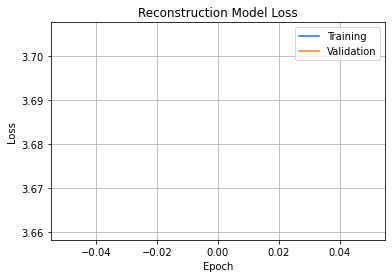

In [19]:
Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model.predict(test_data)
print("Koopman loss: %.4f" %Kloss)

print('Psi_X shape:', Psi_X.shape)
print('Psi_Y shape:', Psi_Y.shape)
print('PSI_X shape:', PSI_X.shape)
print('PSI_X shape:', PSI_Y.shape)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Reconstruction Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

### Find the Koopman operator and check its eigenvalues and sparsity structure 

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 9.904711497290666
[INFO]: Trace of K_deepDMD: 4.187438496471529
[INFO]: One time-step error with K_deepDMD: 36.844721592976256
[Output] Largest 10 eigenvalues of the Koopman operator
------------------------------
[0.9996 0.9851 0.739  0.739  0.7017 0.7017 0.7017 0.7017 0.6941 0.6941]


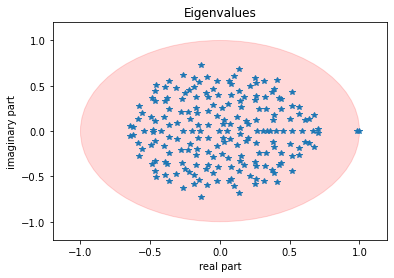

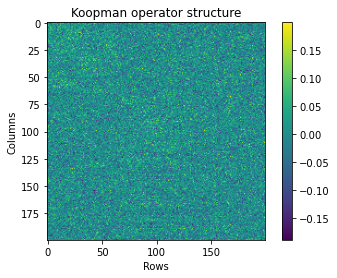

In [20]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK,eigenvectorsK] = np.linalg.eig(K_deepDMD)
abs_eigenvaluesK = np.absolute(eigenvaluesK)#.tolist()
abs_eigenvaluesK_sorted = np.sort(abs_eigenvaluesK)[::-1]
idx_eigenvaluesK_sorted = np.argsort(abs_eigenvaluesK)[::-1]
largest_n_eigenvalues = 10
print('[Output] Largest', largest_n_eigenvalues, 'eigenvalues of the Koopman operator')
print('------------------------------')
print(np.around(abs_eigenvaluesK_sorted[0:largest_n_eigenvalues], decimals = 4))

plt.plot(eigenvaluesK.real, eigenvaluesK.imag, '*')
plt.axis([-1.2, 1.2, -1.2, 1.2])
circle_plot = plt.Circle((0,0),1,alpha=0.15,color = 'r', fill=True)
plt.gcf().gca().add_artist(circle_plot)
# ax.set_aspect('equal')
plt.title('Eigenvalues')
plt.ylabel('imaginary part')
plt.xlabel('real part')
plt.show()

fig = plt.figure()
cs = plt.imshow(K_deepDMD)
plt.title('Koopman operator structure')
plt.xlabel('Rows')
plt.ylabel('Columns')
fig.colorbar(cs)
plt.show()

### Get the neural network weights
- These weights are obtained after adding weight regularization. One can compare these weights with the neural network weights without any weight regularization. We can clearly see sparse structure here. 

13
(128, 128)


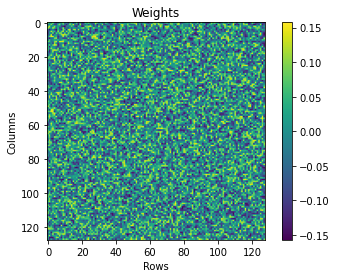

In [21]:
weights = K_model.get_weights()
print(len(weights))
print(weights[2].shape)
fig = plt.figure()
cs = plt.imshow(weights[2])
plt.title('Weights')
plt.xlabel('Rows')
plt.ylabel('Columns')
fig.colorbar(cs)
plt.show()